In [102]:
batch_size = 64
ncomps = 500
crop_size = 180

In [103]:

import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from monai.data import DataLoader
from monai.transforms import Compose, NormalizeIntensity, ToTensor
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

import torchvision.transforms.functional as F

In [104]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')
exp_name = 'far_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/exp_name/'train'

val_csv_path = macaw_path/'splits'/'val.csv'
val_img_path = macaw_path/exp_name/'val'

test_csv_path = macaw_path/'splits'/'test.csv'
test_img_path = macaw_path/exp_name/'test'
# 
pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
val_path = macaw_path/exp_name/f'val_hc_data_PCA_{ncomps}.pkl'
test_path = macaw_path/exp_name/f'test_hc_data_PCA_{ncomps}.pkl'

In [105]:
home_dir = './'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)

train_fpaths = [os.path.join(working_dir, "train", filename) for filename in df_train['filename']]
train_class_label = df_train['class_label']

val_fpaths = [os.path.join(working_dir, "val", filename) for filename in df_val['filename']]
val_class_label = df_val['class_label']

In [106]:
df_train.head()

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filename
0,633,0.469869,2.469359,5,8,5_8,1,1,1_1_8_5,00000_0.47_S_2.469_D_1.289_B.tiff
1,394,0.736736,-1.525330,5,4,5_4,1,0,0_1_4_5,00001_0.737_S_-1.525_D_1.818_B.tiff
2,434,0.791011,-0.026890,5,3,5_3,1,1,1_1_3_5,00002_0.791_S_-0.027_D_1.422_B.tiff
3,685,-0.936475,-0.024416,3,3,3_3,1,1,1_1_3_3,00003_-0.936_S_-0.024_D_1.843_B.tiff
4,537,-0.209586,0.383522,4,4,4_4,1,1,1_1_4_4,00004_-0.21_S_0.384_D_3.023_B.tiff


In [107]:
df_val.head()

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filename
0,640,-0.341310,-1.538284,4,4,4_4,1,0,0_1_4_4,00000_-0.341_S_-1.538_D_2.29_B.tiff
1,117,-0.149281,0.142044,4,4,4_4,1,1,1_1_4_4,00001_-0.149_S_0.142_D_3.108_B.tiff
2,740,-0.555353,-2.209122,3,3,3_3,1,0,0_1_3_3,00002_-0.555_S_-2.209_D_1.999_B.tiff
3,183,0.724953,0.698132,5,5,5_5,1,1,1_1_5_5,00003_0.725_S_0.698_D_3.2_B.tiff
4,625,0.893030,0.959812,6,5,6_5,1,1,1_1_5_6,00004_0.893_S_0.96_D_4.045_B.tiff


In [108]:
if exp_name=='no_bias': 
    df_train['bias_label'].values[:]=0
    df_val['bias_label'].values[:]=0
    
print(df_train.bias_label.mean())
df_val.bias_label.mean()

0.5024875621890548


0.5020080321285141

In [109]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [110]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [111]:
from utils.datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, exp_name=='no_bias',transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

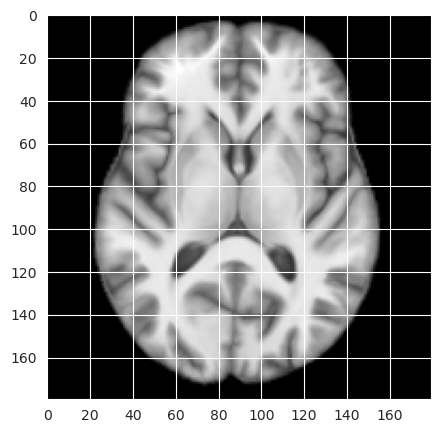

In [112]:
plt.imshow(next(iter(train_loader))[2][1], cmap='gray')

In [113]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

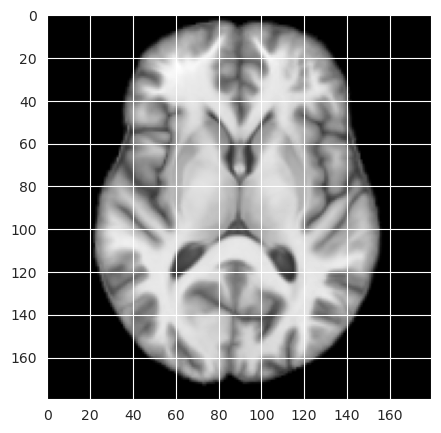

In [114]:
plt.imshow(imgs[0].reshape(crop_size,crop_size), cmap='gray')

## Dimensionality reduction

In [115]:
import pickle
from sklearn.decomposition import PCA

# if os.path.exists(pca_path):
#     with open(pca_path, 'rb') as f:
#         pca = pickle.load(f)
# else:
pca = PCA(n_components=ncomps)
pca.fit(imgs)

with open(pca_path, 'wb') as f:
    pickle.dump(pca, f)

In [116]:
disease = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in train_loader],axis=0)

In [117]:
# Initialize lists to collect data
imgs_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in train_loader:
    imgs_list.append(d[2].numpy())
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())

# Concatenate collected data after the loop
imgs = np.concatenate(imgs_list, axis=0)
imgs = imgs.reshape(imgs.shape[0], -1)
imgs_dim = imgs.shape[1]

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

In [118]:
encoded_data = pca.transform(imgs)

In [119]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)

In [120]:
val_ds = EmmaDataset(val_csv_path, val_img_path, exp_name=='no_bias',transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [121]:
imgs = np.concatenate([d[2].numpy() for d in val_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

In [122]:
disease = np.concatenate([d[0].numpy() for d in val_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in val_loader],axis=0)
encoded_data = pca.transform(imgs)

In [123]:
# Initialize lists to collect data
imgs_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in train_loader:
    imgs_list.append(d[2].numpy())
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())

# Concatenate collected data after the loop
imgs = np.concatenate(imgs_list, axis=0)
imgs = imgs.reshape(imgs.shape[0], -1)
imgs_dim = imgs.shape[1]

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

In [124]:
encoded_data = pca.transform(imgs)

In [125]:
with open(val_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)

In [126]:
test_ds = EmmaDataset(test_csv_path, test_img_path, exp_name=='no_bias', transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [127]:
test_ds.df.loc[test_ds.df['filename']=='00176_0.26_S_-0.941_D_1.539_B.tiff']

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filename
176,310,0.260473,-0.940866,5,5,5_5,1,0,0_1_5_5,00176_0.26_S_-0.941_D_1.539_B.tiff


In [128]:
found = False

j=0

while not found:
    d,b,img,names=next(iter(test_loader))
    j+=1
    
    for i in range(len(d)):
        print(names[i])
        if names[i] == '00176_0.26_S_-0.941_D_1.539_B.tiff':
            found = True
            print(d[i].item())
            print(b[i].item())
            print(i,j)

00064_0.821_S_0.631_D_2.657_B.tiff
00423_-2.202_S_-0.871_D.tiff
00229_0.995_S_2.094_D_-0.453_B.tiff
00140_1.283_S_0.93_D_3.339_B.tiff
00240_0.392_S_1.747_D_0.348_B.tiff
00384_-0.881_S_-0.574_D.tiff
00419_1.332_S_-0.884_D.tiff
00151_1.089_S_1.193_D_2.22_B.tiff
00245_0.452_S_0.217_D_2.801_B.tiff
00498_-0.474_S_-1.127_D.tiff
00020_-0.542_S_-0.187_D_2.585_B.tiff
00234_1.106_S_0.859_D_0.18_B.tiff
00078_-1.146_S_-1.33_D_1.257_B.tiff
00067_-1.022_S_-1.948_D_1.319_B.tiff
00041_0.68_S_-1.798_D_2.334_B.tiff
00300_-0.592_S_1.855_D.tiff
00426_0.288_S_-1.44_D.tiff
00053_1.143_S_0.985_D_3.776_B.tiff
00478_0.07_S_1.121_D.tiff
00472_-0.046_S_-0.831_D.tiff
00206_0.734_S_-0.834_D_2.273_B.tiff
00455_0.481_S_0.852_D.tiff
00244_-0.47_S_-1.306_D_2.336_B.tiff
00231_0.69_S_1.868_D_4.475_B.tiff
00001_-0.997_S_-1.156_D_2.455_B.tiff
00027_-0.078_S_-0.977_D_1.012_B.tiff
00377_-1.317_S_0.082_D.tiff
00065_-1.366_S_1.083_D_1.39_B.tiff
00450_0.981_S_1.151_D.tiff
00315_0.064_S_0.216_D.tiff
00284_-1.002_S_0.368_D.tiff


In [129]:
found = False

while not found:
    d,b,img,names=next(iter(test_loader))
    j+=1
    
    for i in range(len(d)):
        if names[i] == '00176_0.26_S_-0.941_D_1.539_B.tiff':
            found = True
            print(d[i].item())
            print(b[i].item())
            print(i,j)

0
1
19 5


In [130]:
d,b,img,names = next(iter(test_loader))

In [131]:
test_ds.df.isna().sum()

Unnamed: 0     0
isv_dst        0
effect_dst     0
isv_bin        0
effect_bin     0
both_bins      0
bias_label     0
class_label    0
strat_col      0
filename       0
dtype: int64

In [132]:
test_ds.df.shape

(499, 10)

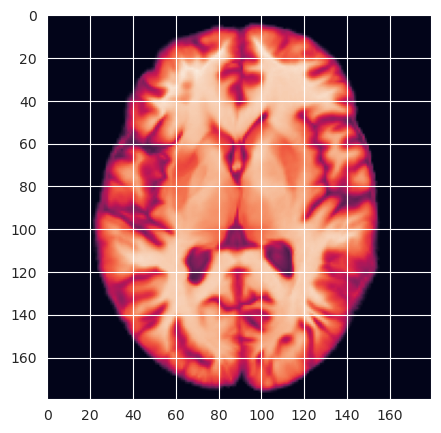

In [133]:
plt.imshow(next(iter(train_loader))[2][1])

In [134]:
test_imgs = np.concatenate([d[2].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

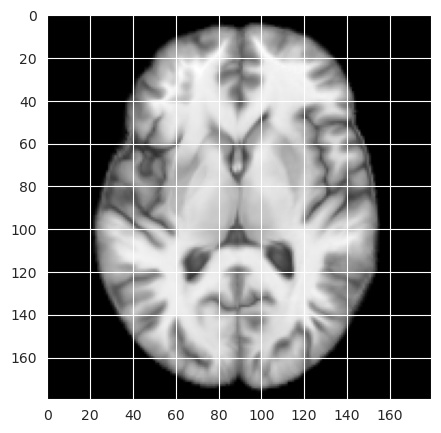

In [135]:
plt.imshow(test_imgs[1].reshape(crop_size,crop_size), cmap='gray')

In [136]:
test_img_names = np.concatenate([d[3] for d in test_loader],axis=0)
test_img_names[:5]

array(['00111_0.289_S_1.455_D_3.162_B.tiff',
       '00339_0.924_S_-1.235_D.tiff',
       '00148_0.255_S_-0.571_D_0.595_B.tiff',
       '00177_-1.825_S_0.626_D_2.042_B.tiff',
       '00229_0.995_S_2.094_D_-0.453_B.tiff'], dtype='<U37')

In [137]:
bias[174]

0

In [138]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

Disease: [1 1 0 1 1]
Bias: [0 1 1 1 1]


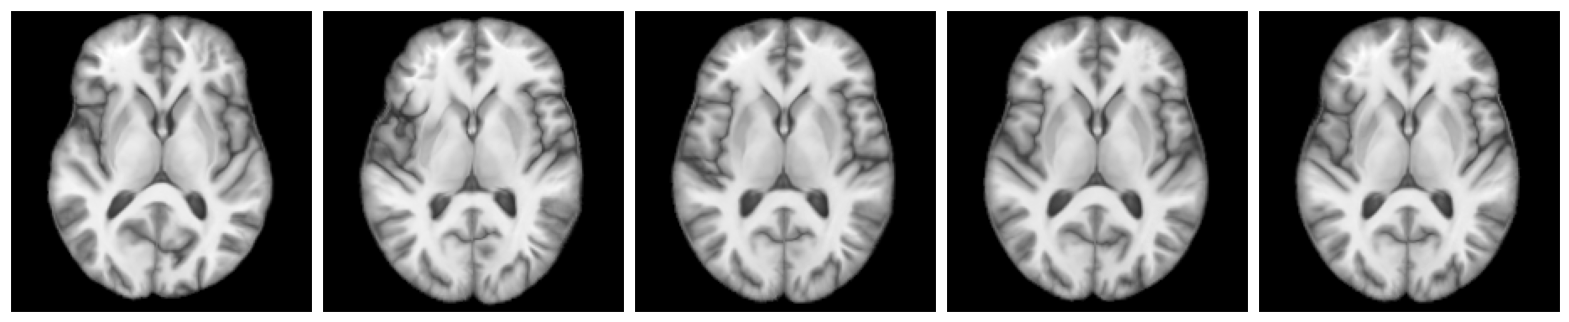

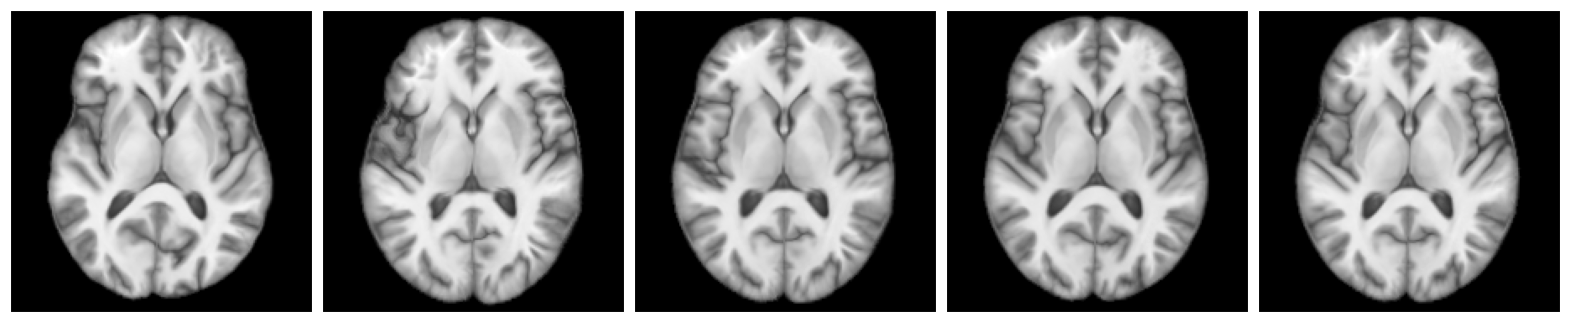

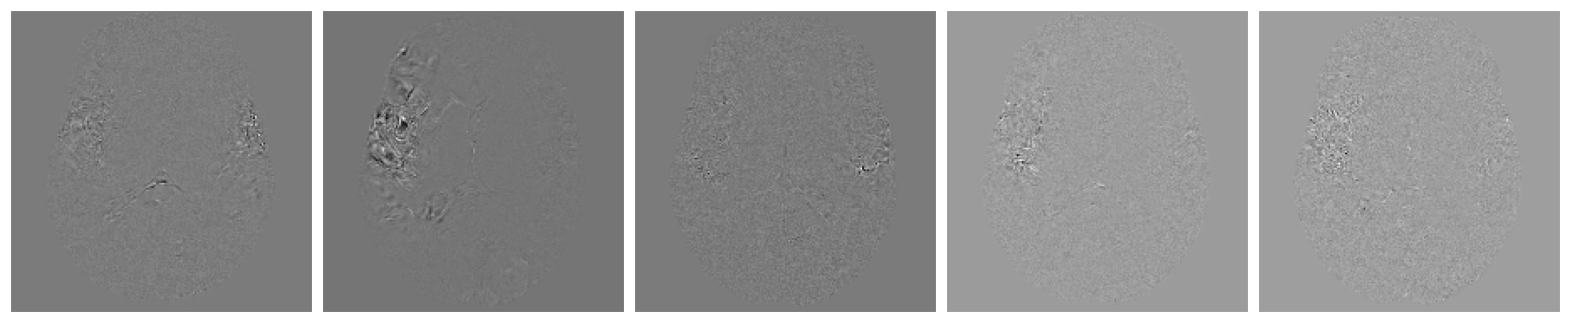

In [139]:
import utils.visualize as vis
print("Disease:", disease[:5])
print("Bias:",bias[:5])

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in diff],cols=5, cmap='gray')

In [140]:
disease = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in test_loader],axis=0)
encoded_data = pca.transform(test_imgs)

In [141]:
# Initialize lists to collect data
test_imgs_list = []
test_img_names_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in test_loader:
    test_imgs_list.append(d[2].numpy())
    test_img_names_list.append(d[3])
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    
# Concatenate collected data after the loop
test_imgs = np.concatenate(test_imgs_list, axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0], -1)
test_imgs_dim = test_imgs.shape[1]

test_img_names = np.concatenate(test_img_names_list, axis=0)

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

In [142]:
np.min(X_recon)

-0.02592343

In [143]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data, 'img_names':test_img_names}, f)